In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf

In [2]:
# Importing dataframe (Armchair Analysis Play-by-Play)
df = pd.read_csv('PBP2.csv')

In [3]:
# Format data to only use plays resulting in a pass or rush
df = df[df['type'].isin(['PASS', 'RUSH'])]

# Remove/drop columns unnecessary for prediction
df = df.drop(["gid","pid","detail","zone","yds"], axis = 1)


In [4]:
# Create new column for total seconds remaining
qtr_sec = df["qtr"] * 15 * 60
min_sec = df["min"] * 60
tot_sec_rem = qtr_sec + min_sec + df["sec"]
df["tot_sec_rem"] = tot_sec_rem

In [5]:
# Create new column for yards to endzone
yds_to_endzone = 100 - df["yfog"]
df["yds_to_endzone"] = yds_to_endzone

In [6]:
print(df.head())

off  def  type  dseq  len  qtr  min  sec  ptso  ptsd  timo  timd  dwn  \
2  ATL  PHI  PASS     1   30    1   15    0     0     0     3     3  1.0   
3  ATL  PHI  RUSH     2   36    1   14   22     0     0     3     3  2.0   
4  ATL  PHI  RUSH     3   36    1   13   46     0     0     3     3  1.0   
5  ATL  PHI  PASS     4    5    1   13   10     0     0     3     3  1.0   
6  ATL  PHI  PASS     5    4    1   13    5     0     0     3     3  2.0   

    ytg  yfog  tot_sec_rem  yds_to_endzone  
2  15.0  20.0         1800            80.0  
3   5.0  30.0         1762            70.0  
4  10.0  41.0         1726            59.0  
5  10.0  61.0         1690            39.0  
6  10.0  61.0         1685            39.0  


In [7]:
# Remove/drop used columns
df = df.drop(["qtr","min","sec","yfog"], axis = 1)

In [8]:
print(df.head())

off  def  type  dseq  len  ptso  ptsd  timo  timd  dwn   ytg  tot_sec_rem  \
2  ATL  PHI  PASS     1   30     0     0     3     3  1.0  15.0         1800   
3  ATL  PHI  RUSH     2   36     0     0     3     3  2.0   5.0         1762   
4  ATL  PHI  RUSH     3   36     0     0     3     3  1.0  10.0         1726   
5  ATL  PHI  PASS     4    5     0     0     3     3  1.0  10.0         1690   
6  ATL  PHI  PASS     5    4     0     0     3     3  2.0  10.0         1685   

   yds_to_endzone  
2            80.0  
3            70.0  
4            59.0  
5            39.0  
6            39.0  


In [9]:
# Re-order columns to place y variable in first column (index = 0)
df = df[['type','off','def','dseq','len','tot_sec_rem','ptso','ptsd','timo','timd','dwn','ytg','yds_to_endzone']]

In [10]:
# Get dummy variables for categorical columns
df_dummies = pd.get_dummies(df, columns=['off', 'def'], drop_first= True)

In [11]:
# Split X and y variables
y = df_dummies.iloc[:, 0].values
X = df_dummies.drop(columns=['type']).values

In [12]:
# Splitting the dataframe into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [13]:
# Fitting XGBoost to the training set
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [14]:
# Predicting the test set results
y_pred = classifier.predict(X_test)

In [15]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [16]:
# Applying k-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

In [17]:
# Find mean of accuracies
accuracies.mean()

0.7700447438732991

In [18]:
# Find standard deviation of accuracies
accuracies.std()

0.006072507233328049

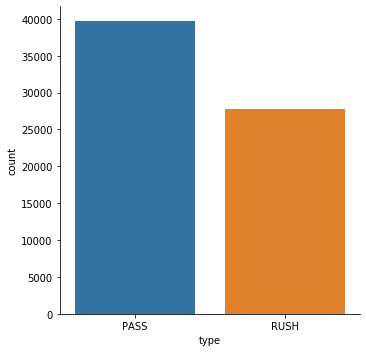

In [19]:
# Number of PASS plays vs RUSH plays - entire NFL
sns.catplot(x='type', kind='count', data=df, orient='h')
plt.show()

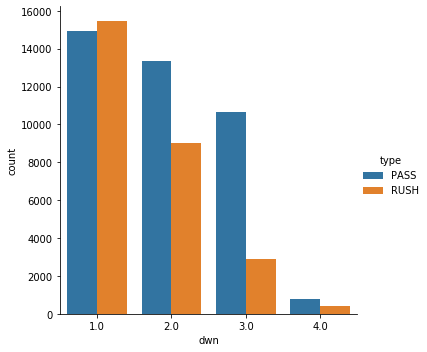

In [20]:
# PASS plays vs RUSH plays by down - entire NFL
sns.catplot(x="dwn", kind="count", hue='type', data=df)
plt.show()

In [21]:
df.head()

,type,off,def,dseq,len,tot_sec_rem,ptso,ptsd,timo,timd,dwn,ytg,yds_to_endzone
2,PASS,ATL,PHI,1,30,1800,0,0,3,3,1.0,15.0,80.0
3,RUSH,ATL,PHI,2,36,1762,0,0,3,3,2.0,5.0,70.0
4,RUSH,ATL,PHI,3,36,1726,0,0,3,3,1.0,10.0,59.0
5,PASS,ATL,PHI,4,5,1690,0,0,3,3,1.0,10.0,39.0
6,PASS,ATL,PHI,5,4,1685,0,0,3,3,2.0,10.0,39.0


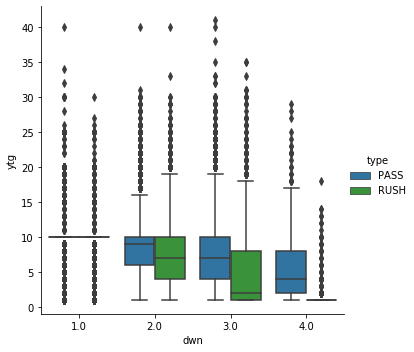

In [22]:
# PASS plays vs RUSH plays by down (dwn) and yards-to-go (ytg) for 1st down - entire NFL
palette = {"RUSH": "C2", "PASS": "C0"}
g = sns.catplot(x='dwn', y='ytg', kind='box', data=df, hue='type', hue_order={"RUSH", "PASS"},palette=palette)

In [23]:
df.describe()

,dseq,len,tot_sec_rem,ptso,ptsd,timo,timd,dwn,ytg,yds_to_endzone
count,67552.000000,67552.000000,67552.000000,67552.000000,67552.000000,67552.000000,67552.000000,67552.000000,67552.000000,67552.000000
mean,4.229527,27.051990,2738.638664,10.582396,12.075719,2.563477,2.581522,1.786135,8.660735,51.516787
std,2.912760,15.234658,1044.074963,9.763539,10.347820,0.762861,0.721875,0.822037,3.971663,24.342407
min,1.000000,1.000000,900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,8.000000,1839.000000,3.000000,3.000000,2.000000,2.000000,1.000000,6.000000,33.000000
50%,3.000000,33.000000,2731.500000,9.000000,10.000000,3.000000,3.000000,2.000000,10.000000,55.000000
75%,6.000000,40.000000,3675.000000,17.000000,19.000000,3.000000,3.000000,2.000000,10.000000,72.000000
max,21.000000,78.000000,5400.000000,59.000000,59.000000,3.000000,3.000000,4.000000,41.000000,99.000000


In [24]:
print(df.describe(include='all'))

type    off    def          dseq           len   tot_sec_rem  \
count   67552  67552  67552  67552.000000  67552.000000  67552.000000   
unique      2     32     32           NaN           NaN           NaN   
top      PASS     NE     KC           NaN           NaN           NaN   
freq    39708   2467   2489           NaN           NaN           NaN   
mean      NaN    NaN    NaN      4.229527     27.051990   2738.638664   
std       NaN    NaN    NaN      2.912760     15.234658   1044.074963   
min       NaN    NaN    NaN      1.000000      1.000000    900.000000   
25%       NaN    NaN    NaN      2.000000      8.000000   1839.000000   
50%       NaN    NaN    NaN      3.000000     33.000000   2731.500000   
75%       NaN    NaN    NaN      6.000000     40.000000   3675.000000   
max       NaN    NaN    NaN     21.000000     78.000000   5400.000000   

                ptso          ptsd          timo          timd           dwn  \
count   67552.000000  67552.000000  67552.000000  67

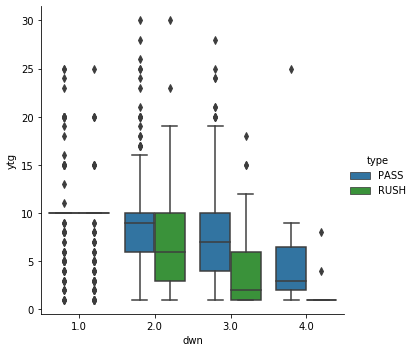

In [25]:
# PASS plays vs RUSH plays by down (dwn) and yards-to-go (ytg) for 1st down - KC Chiefs Offense
df_off_KC = df[df['off'].isin(['KC'])]
palette = {"RUSH": "C2", "PASS": "C0"}
g = sns.catplot(x='dwn', y='ytg', kind='box', data=df_off_KC, hue='type', hue_order={"RUSH", "PASS"},palette=palette)

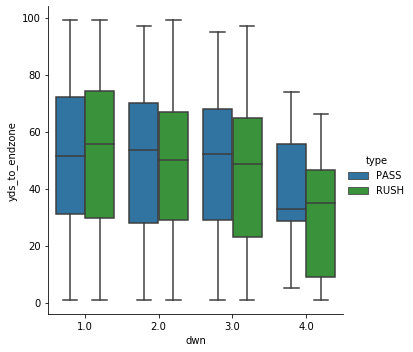

In [26]:
# PASS plays vs RUSH plays by down (dwn) and distance for touchdown (yds_to_endzone) - KC Chiefs Offense
df_off_KC = df[df['off'].isin(['KC'])]
palette = {"RUSH": "C2", "PASS": "C0"}
g = sns.catplot(x='dwn', y='yds_to_endzone', kind='box', data=df_off_KC, hue='type', hue_order={"RUSH", "PASS"},palette=palette)

In [27]:
df_off_KC.describe()

,dseq,len,tot_sec_rem,ptso,ptsd,timo,timd,dwn,ytg,yds_to_endzone
count,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000
mean,4.377071,26.830863,2711.994769,15.600262,11.339582,2.585876,2.573235,1.734961,8.564080,49.166957
std,2.931165,15.690675,1043.730989,11.584055,9.744276,0.656605,0.758495,0.804711,3.906009,24.847262
min,1.000000,1.000000,900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,7.000000,1844.250000,7.000000,3.000000,2.000000,2.000000,1.000000,6.000000,29.000000
50%,4.000000,33.000000,2700.000000,14.000000,10.000000,3.000000,3.000000,2.000000,10.000000,52.000000
75%,6.000000,40.000000,3639.000000,23.000000,17.000000,3.000000,3.000000,2.000000,10.000000,70.000000
max,16.000000,61.000000,5100.000000,51.000000,54.000000,3.000000,3.000000,4.000000,30.000000,99.000000


In [28]:
print(df_off_KC.describe(include='all'))

type   off   def         dseq          len  tot_sec_rem         ptso  \
count   2294  2294  2294  2294.000000  2294.000000  2294.000000  2294.000000   
unique     2     1    20          NaN          NaN          NaN          NaN   
top     PASS    KC   OAK          NaN          NaN          NaN          NaN   
freq    1409  2294   249          NaN          NaN          NaN          NaN   
mean     NaN   NaN   NaN     4.377071    26.830863  2711.994769    15.600262   
std      NaN   NaN   NaN     2.931165    15.690675  1043.730989    11.584055   
min      NaN   NaN   NaN     1.000000     1.000000   900.000000     0.000000   
25%      NaN   NaN   NaN     2.000000     7.000000  1844.250000     7.000000   
50%      NaN   NaN   NaN     4.000000    33.000000  2700.000000    14.000000   
75%      NaN   NaN   NaN     6.000000    40.000000  3639.000000    23.000000   
max      NaN   NaN   NaN    16.000000    61.000000  5100.000000    51.000000   

               ptsd         timo         timd  

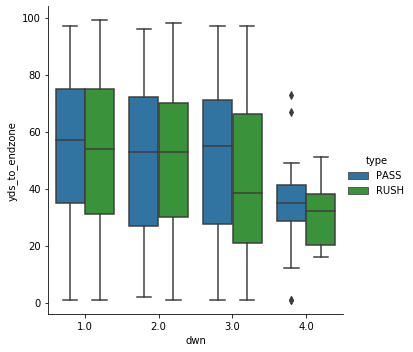

In [29]:
# PASS plays vs RUSH plays by down (dwn) and distance for touchdown (yds_to_endzone) - SF 49ers Offense
df_off_SF = df[df['off'].isin(['SF'])]
palette = {"RUSH": "C2", "PASS": "C0"}
g = sns.catplot(x='dwn', y='yds_to_endzone', kind='box', data=df_off_SF, hue='type', hue_order={"RUSH", "PASS"},palette=palette)

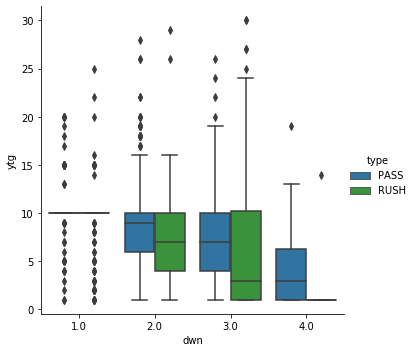

In [30]:
# PASS plays vs RUSH plays by down (dwn) and yards-to-go (ytg) for 1st down - SF 49ers Offense
df_off_SF = df[df['off'].isin(['SF'])]
palette = {"RUSH": "C2", "PASS": "C0"}
g = sns.catplot(x='dwn', y='ytg', kind='box', data=df_off_SF, hue='type', hue_order={"RUSH", "PASS"},palette=palette)

In [31]:
df_off_SF.describe()

,dseq,len,tot_sec_rem,ptso,ptsd,timo,timd,dwn,ytg,yds_to_endzone
count,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000
mean,4.162706,27.970293,2747.438757,12.413163,12.021481,2.485375,2.553016,1.748629,8.718921,50.338665
std,2.958181,15.390973,1040.673100,10.553855,10.922640,0.779402,0.761094,0.800590,3.939421,25.028124
min,1.000000,1.000000,906.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,9.000000,1843.500000,3.000000,3.000000,2.000000,2.000000,1.000000,6.000000,30.000000
50%,3.000000,35.000000,2774.000000,10.000000,10.000000,3.000000,3.000000,2.000000,10.000000,53.000000
75%,6.000000,41.000000,3659.500000,20.000000,19.000000,3.000000,3.000000,2.000000,10.000000,72.000000
max,21.000000,60.000000,4945.000000,51.000000,48.000000,3.000000,3.000000,4.000000,30.000000,99.000000


In [32]:
print(df_off_SF.describe(include='all'))

type   off   def         dseq          len  tot_sec_rem         ptso  \
count   2188  2188  2188  2188.000000  2188.000000  2188.000000  2188.000000   
unique     2     1    21          NaN          NaN          NaN          NaN   
top     PASS    SF   ARI          NaN          NaN          NaN          NaN   
freq    1156  2188   290          NaN          NaN          NaN          NaN   
mean     NaN   NaN   NaN     4.162706    27.970293  2747.438757    12.413163   
std      NaN   NaN   NaN     2.958181    15.390973  1040.673100    10.553855   
min      NaN   NaN   NaN     1.000000     1.000000   906.000000     0.000000   
25%      NaN   NaN   NaN     2.000000     9.000000  1843.500000     3.000000   
50%      NaN   NaN   NaN     3.000000    35.000000  2774.000000    10.000000   
75%      NaN   NaN   NaN     6.000000    41.000000  3659.500000    20.000000   
max      NaN   NaN   NaN    21.000000    60.000000  4945.000000    51.000000   

               ptsd         timo         timd  